# Decision Tree Max Depth Animation

This notebook creates an animation showing how the decision boundary of a DecisionTreeClassifier changes as the `max_depth` parameter increases.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML

## Generate Dataset

First, let's create datasets for our visualization. We'll create three different types of datasets: linearly separable, moons, and circles.

In [2]:
# Set random state for reproducibility
random_state = 42

# Generate datasets
# Linearly separable dataset
X_linear, y_linear = make_classification(
    n_samples=300, n_features=2, n_redundant=0, n_informative=2,
    random_state=random_state, n_clusters_per_class=1, class_sep=0.8
)

# Moons dataset
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=random_state)

# Circles dataset
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, random_state=random_state, factor=0.5)

## Visualize the datasets

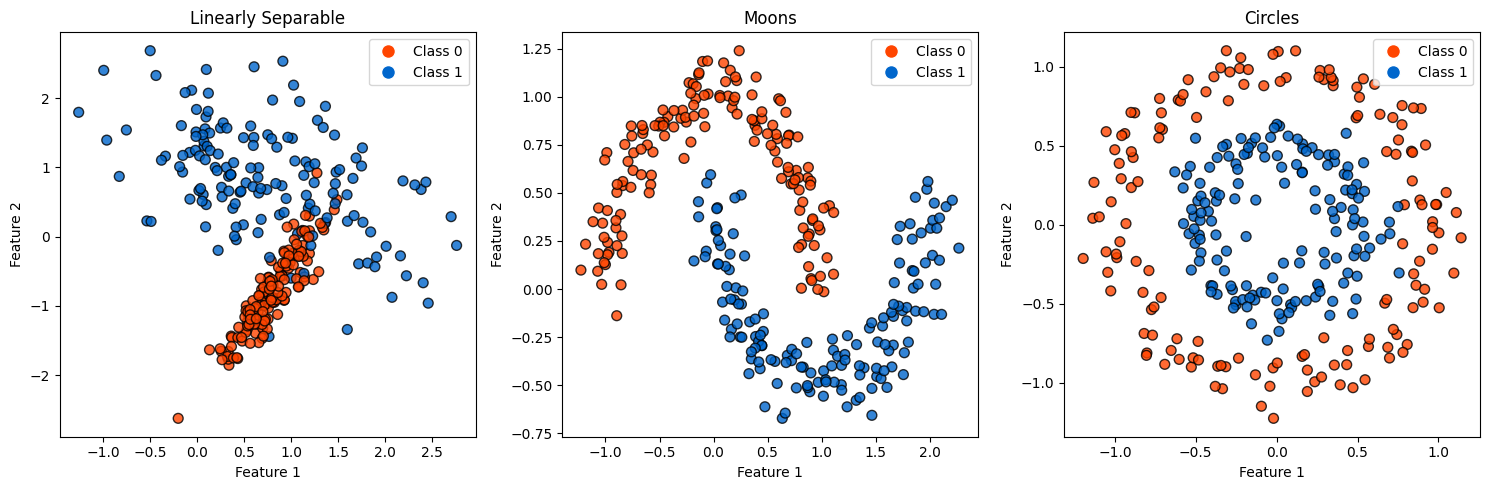

In [3]:
# Plot all datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [
    (X_linear, y_linear, "Linearly Separable"),
    (X_moons, y_moons, "Moons"),
    (X_circles, y_circles, "Circles")
]

# Define high contrast colors
colors = ['#FF4500', '#0066CC']  # Vibrant orange and blue
cmap = plt.cm.colors.ListedColormap(colors)

for ax, (X, y, title) in zip(axes, datasets):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', s=50, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    # Add a legend for clarity
    scatter_0 = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='Class 0')
    scatter_1 = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='Class 1')
    ax.legend(handles=[scatter_0, scatter_1], loc='upper right')

plt.tight_layout()
plt.show()

## Create Animation Function

Now, let's create a function to generate an animation that shows how the decision boundary changes as the max_depth parameter increases.

In [4]:
def create_decision_boundary_animation(X, y, max_depths=range(1, 11), interval=500, dataset_name="Dataset"):
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create a meshgrid
    h = 0.02  # Step size in the mesh
    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define high contrast colors
    colors = ['#FF4500', '#0066CC']  # Vibrant orange and blue
    cmap = plt.cm.colors.ListedColormap(colors)
    
    # Initialize scatter plot for data points
    scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=cmap, edgecolors='k', s=50, alpha=0.8)
    
    # Add a legend for clarity
    scatter_0 = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='Class 0')
    scatter_1 = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='Class 1')
    ax.legend(handles=[scatter_0, scatter_1], loc='upper right')
    
    # Initialize model with first max_depth and get initial boundary
    model_init = DecisionTreeClassifier(max_depth=max_depths[0], random_state=random_state)
    model_init.fit(X_scaled, y)
    Z_init = model_init.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Initialize contour for decision boundary
    contourf_object = ax.contourf(xx, yy, Z_init, alpha=0.3, levels=np.linspace(0, 1, 3), cmap=cmap)
    
    # Title with parameter info
    title = ax.set_title(f"{dataset_name} - max_depth: {max_depths[0]}", fontsize=14, fontweight='bold')
    
    # Stats text
    n_nodes_init = model_init.tree_.node_count
    n_leaves_init = model_init.tree_.n_leaves
    depth_init = model_init.tree_.max_depth
    accuracy_init = model_init.score(X_scaled, y)
    
    stats_text = ax.text(0.02, 0.02, 
                        f'Nodes: {n_nodes_init}\nLeaves: {n_leaves_init}\nDepth: {depth_init}\nAccuracy: {accuracy_init:.2f}', 
                        transform=ax.transAxes, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9),
                        fontsize=12)
    
    ax.set_xlabel('Feature 1', fontsize=12)
    ax.set_ylabel('Feature 2', fontsize=12)
    
    # Animation update function
    def update(frame):
        # Declare variables from outer scope that will be modified
        nonlocal contourf_object
        
        max_depth = max_depths[frame]
        
        # Train model with the current max_depth
        model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
        model.fit(X_scaled, y)
        
        # Get predictions for each point in the meshgrid
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Clear previous contour collections
        for c in contourf_object.collections:
            c.remove()
            
        # Create new contour plot with the same color scheme
        contourf_object = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.linspace(0, 1, 3), cmap=cmap)
        
        # Update title
        title.set_text(f"{dataset_name} - max_depth: {max_depth}")
        
        # Get tree complexity metrics
        n_nodes = model.tree_.node_count
        n_leaves = model.tree_.n_leaves
        depth = model.tree_.max_depth
        accuracy = model.score(X_scaled, y)
        
        # Update stats text
        stats_text.set_text(f'Nodes: {n_nodes}\nLeaves: {n_leaves}\nDepth: {depth}\nAccuracy: {accuracy:.2f}')
        
        return [title, stats_text]
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(max_depths), interval=interval, blit=True)
    
    plt.close()  # Prevent double display in notebook
    
    return anim

## Generate Animations for Each Dataset

Now let's create and display animations for each of our datasets.

In [5]:
# Create animation for linearly separable dataset
anim_linear = create_decision_boundary_animation(X_linear, y_linear, max_depths=range(1, 11), dataset_name="Linearly Separable", interval=800)
HTML(anim_linear.to_jshtml())

/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbw

In [6]:
# Create animation for moons dataset
anim_moons = create_decision_boundary_animation(X_moons, y_moons, max_depths=range(1, 11), dataset_name="Moons", interval=800)
HTML(anim_moons.to_jshtml())

/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbw

In [7]:
# Create animation for circles dataset
anim_circles = create_decision_boundary_animation(X_circles, y_circles, max_depths=range(1, 11), dataset_name="Circles", interval=800)
HTML(anim_circles.to_jshtml())

## Save Animations (Optional)

You can save the animations as GIF files if you want to use them elsewhere.

In [7]:
# Uncomment the code below if you want to save the animations

# Try to save animations as GIFs if pillow is installed
try:
    # Save animations
    anim_linear.save('linear_max_depth_animation.gif', writer='pillow', fps=2)
    anim_moons.save('moons_max_depth_animation.gif', writer='pillow', fps=2)
    anim_circles.save('circles_max_depth_animation.gif', writer='pillow', fps=2)
    print("Animations saved as GIFs.")
except Exception as e:
    print(f"Could not save animations: {e}")
    print("You may need to install additional dependencies like 'pillow'.")

/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbwvjhr0000gp/T/ipykernel_24883/1795798600.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contourf_object.collections:
/var/folders/z2/kpj7bddd1j9d6d9lwfbw

Could not save animations: name 'anim_circles' is not defined
You may need to install additional dependencies like 'pillow'.


## Observations

From these animations, we can observe:

1. **Linearly Separable Data**: Even a tree with a small max_depth can find a good decision boundary for linearly separable data. As the max_depth increases, the boundary gets more complex but may not significantly improve accuracy.

2. **Moons Data**: This non-linear pattern requires a deeper tree to capture the curved decision boundary. Too shallow trees cannot model the curved shape correctly.

3. **Circles Data**: This is the most complex pattern and requires the deepest tree to approximate the circular decision boundary properly.

**Overfitting vs. Underfitting**:
- Small max_depth: The model can underfit, failing to capture the data's true pattern
- Large max_depth: The model might overfit, creating an overly complex decision boundary that performs well on training data but may not generalize well to new data

The animations visually demonstrate how the max_depth parameter directly controls the complexity of the decision tree model.